Last Updated: 08-09-2017

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Masking" data-toc-modified-id="Masking-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Masking</a></div><div class="lev2 toc-item"><a href="#Masking-with-where:" data-toc-modified-id="Masking-with-where:-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Masking with where:</a></div><div class="lev2 toc-item"><a href="#Buliding-the-mask:" data-toc-modified-id="Buliding-the-mask:-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Buliding the mask:</a></div><div class="lev2 toc-item"><a href="#Mask-as-Coordinates" data-toc-modified-id="Mask-as-Coordinates-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Mask as Coordinates</a></div><div class="lev2 toc-item"><a href="#Key-Points" data-toc-modified-id="Key-Points-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Key Points</a></div>

# Masking

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.figsize'] = (12, 15)
import numpy as np
import pandas as pd
import seaborn as sns
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
import xarray as xr
from cartopy import crs

hv.notebook_extension()

## Masking with where:
So far we have used indexing to return subsets of the original. The subset array shape will be different from the original. However, we often want to retain the array shape and mask out some observations. There are applications here in remote sensing, land cover modeling, etc.

Suppose we need to determine which grid cells had temperatures > 20 deg C on January 16, 1950 will use ```where()``` for this selection:

In [2]:
ds = xr.open_dataset('/home/abanihi/Documents/climate-data/CMIP/CMIP5/NCAR/CCSM4/historical/mon/atmos/Amon/r6i1p1/v20160829/ta_Amon_CCSM4_historical_r6i1p1_195001-200512.nc', chunks={'lat':10, 'lon':10}).isel(plev=0)

In [3]:
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 192, lon: 288, time: 672)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-16T12:00:00 1950-02-15 ...
    plev       float64 1e+05
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 3.65e+04 3.653e+04 3.653e+04 3.656e+04 ...
    lat_bnds   (lat, bnds) float64 -90.0 -89.53 -89.53 -88.59 -88.59 -87.64 ...
    lon_bnds   (lon, bnds) float64 -0.625 0.625 0.625 1.875 1.875 3.125 ...
    ta         (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
Attributes:
    institution:                  NCAR (National Center for Atmospheric Resea...
    institute_id:                 NCAR
    experiment_id:                historical
    source:                       CCSM4
    model_id:                     CCSM4
    forcing:               

In [4]:
delta = ds['ta'].isel(time=0)

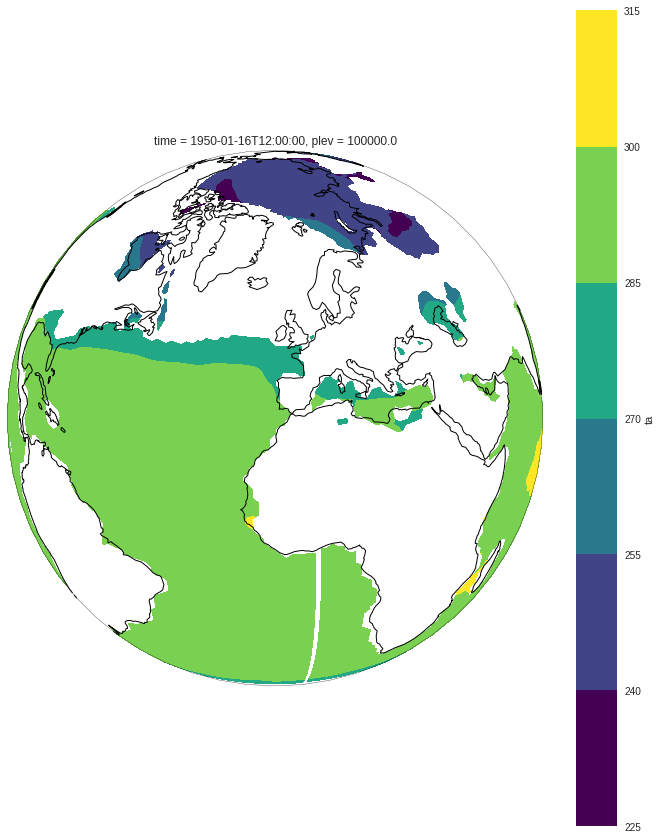

In [5]:
ax = plt.axes(projection=crs.Orthographic(-10, 35))
delta.plot.contourf(ax=ax, transform=crs.PlateCarree());
ax.set_global(); ax.coastlines();

[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.9s


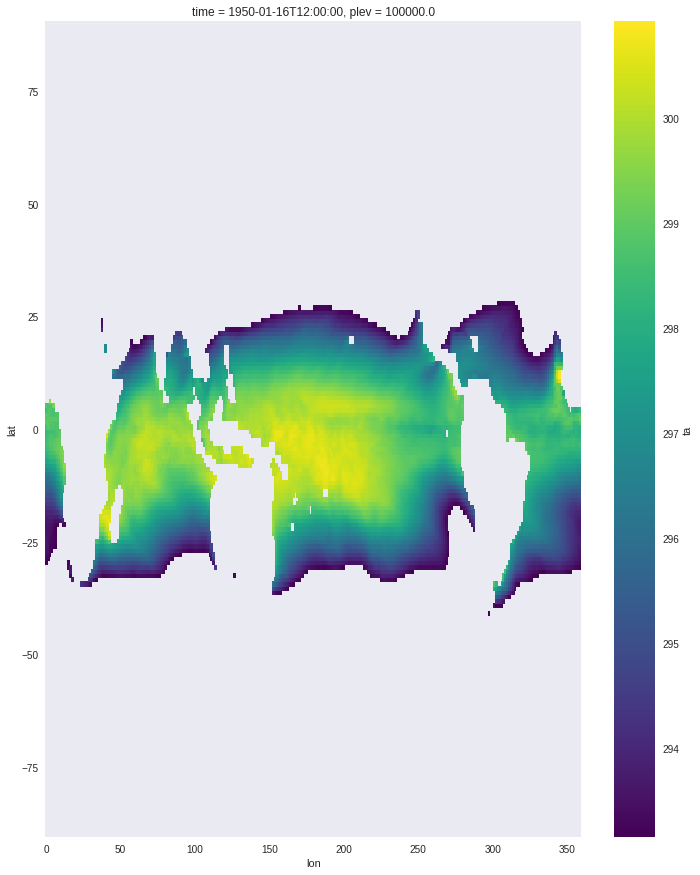

In [6]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    ds['ta'].isel(time=0).where(ds.ta.isel(time=0) > 293.15).plot()

## Buliding the mask:
Here we’ll use some lower-level numpy commands to build the mask (and we’ll need to import the numpy library). The mask number depends on whether the cells are finite or NaN:

[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  0.9s


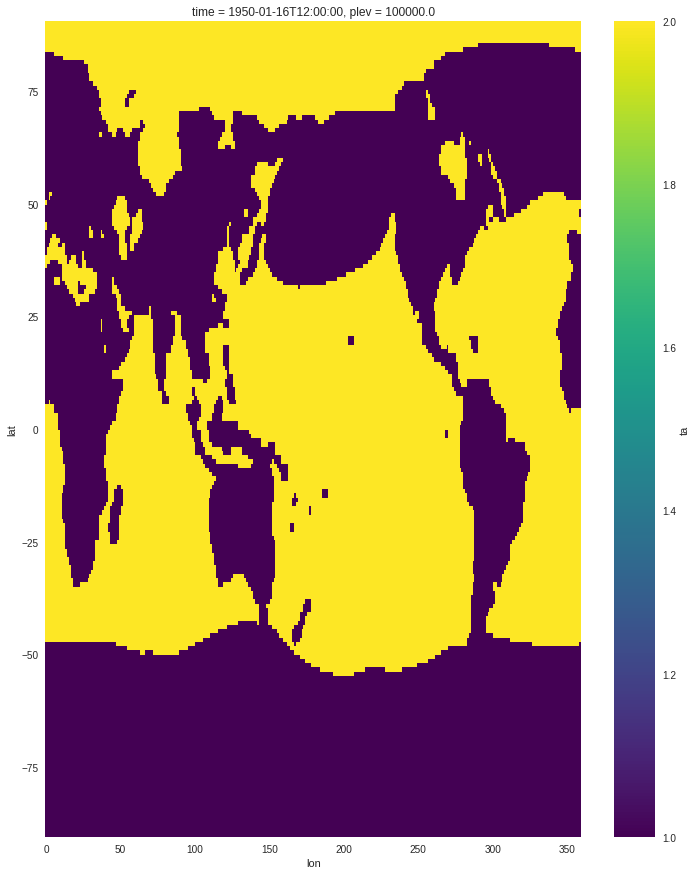

In [7]:
with ProgressBar():
    mask_ocean = 2 * np.ones((ds.dims['lat'], ds.dims['lon'])) * np.isfinite(ds.ta.isel(time=0))  
    mask_land = 1 * np.ones((ds.dims['lat'], ds.dims['lon'])) * np.isnan(ds.ta.isel(time=0))  
    mask_array = mask_ocean + mask_land
    mask_array.plot()

## Mask as Coordinates
We can keep the mask as a separate array entity, or, if we are using it routinely, there are advantages to adding it as a coordinate to the DataArray:

In [8]:
ds.coords['mask'] = (('lat', 'lon'), mask_array)
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 192, lon: 288, time: 672)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-16T12:00:00 1950-02-15 ...
    plev       float64 1e+05
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
    mask       (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 3.65e+04 3.653e+04 3.653e+04 3.656e+04 ...
    lat_bnds   (lat, bnds) float64 -90.0 -89.53 -89.53 -88.59 -88.59 -87.64 ...
    lon_bnds   (lon, bnds) float64 -0.625 0.625 0.625 1.875 1.875 3.125 ...
    ta         (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
Attributes:
    institution:                  NCAR (National Center for Atmospheric Resea...
    institute_id:                 NCAR
    experiment_id:                historical
    source:                  

Now that the mask is integrated into the coordinates, we can easily apply the mask using ```where()```. We can integrate this with statistical functions operating on the array:



[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.1s


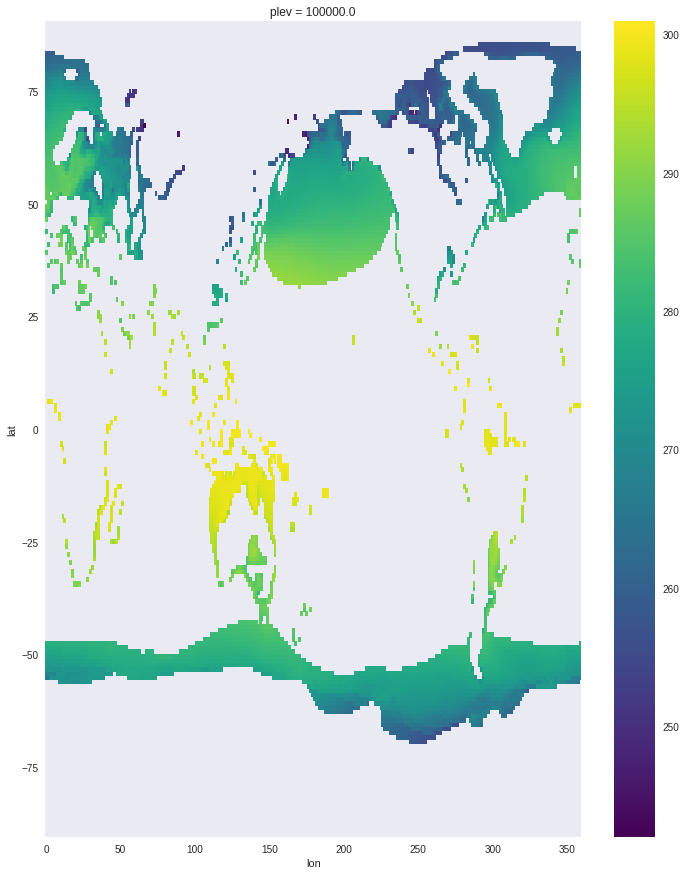

In [9]:
with ProgressBar():
    ds['ta'].mean('time').where(ds.mask == 1).plot()

## Key Points

- xarray provides tools for creating and analyzing masked data.
